In [1]:
import torch

checkpoint_ctgenerate = torch.load("/project/project_465001111/ct_clip/pretrained_models/ctgenerate.pt", map_location=torch.device('cpu'))
# checkpoint_ctvit = torch.load("/project/project_465001111/ct_clip/pretrained_models/generate_ctvit.pt", map_location=torch.device('cpu'))

if isinstance(checkpoint_generate, dict) and 'state_dict' in checkpoint_generate:
    state_dict = checkpoint_generate['state_dict']
else:
    state_dict = checkpoint_generate

for name, param in state_dict.items():
    print(f"{name}: {param.shape}")

ctvit.spatial_rel_pos_bias.net.0.0.weight: torch.Size([512, 2])
ctvit.spatial_rel_pos_bias.net.0.0.bias: torch.Size([512])
ctvit.spatial_rel_pos_bias.net.1.0.weight: torch.Size([512, 512])
ctvit.spatial_rel_pos_bias.net.1.0.bias: torch.Size([512])
ctvit.spatial_rel_pos_bias.net.2.weight: torch.Size([8, 512])
ctvit.spatial_rel_pos_bias.net.2.bias: torch.Size([8])
ctvit.to_patch_emb_first_frame.1.weight: torch.Size([256])
ctvit.to_patch_emb_first_frame.1.bias: torch.Size([256])
ctvit.to_patch_emb_first_frame.2.weight: torch.Size([512, 256])
ctvit.to_patch_emb_first_frame.2.bias: torch.Size([512])
ctvit.to_patch_emb_first_frame.3.weight: torch.Size([512])
ctvit.to_patch_emb_first_frame.3.bias: torch.Size([512])
ctvit.to_patch_emb.1.weight: torch.Size([512])
ctvit.to_patch_emb.1.bias: torch.Size([512])
ctvit.to_patch_emb.2.weight: torch.Size([512, 512])
ctvit.to_patch_emb.2.bias: torch.Size([512])
ctvit.to_patch_emb.3.weight: torch.Size([512])
ctvit.to_patch_emb.3.bias: torch.Size([512])
c

In [3]:
# Define prefixes to remove
prefixes_to_remove = [
    "ctvit.dec_temporal_transformer",
    "ctvit.dec_spatial_transformer",
    "ctvit.to_pixels_first_frame",
    "ctvit.to_pixels"
]

# Filter out keys that start with any of the above prefixes
filtered_state_dict = {
    k: v for k, v in state_dict.items()
    if not any(k.startswith(prefix) for prefix in prefixes_to_remove)
}

# Save under a new filename
new_path = "/project/project_465001111/ct_clip/pretrained_models/generate_filtered.pt"
if 'state_dict' in checkpoint_generate:
    new_checkpoint = checkpoint_generate.copy()
    new_checkpoint['state_dict'] = filtered_state_dict
    torch.save(new_checkpoint, new_path)
else:
    torch.save(filtered_state_dict, new_path)

In [14]:
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

In [17]:
import torch.nn.functional as F

def resize_array(array, current_spacing, target_spacing):
    """
    Resize the array to match the target spacing.

    Args:
    array (torch.Tensor): Input array to be resized.
    current_spacing (tuple): Current voxel spacing (z_spacing, xy_spacing, xy_spacing).
    target_spacing (tuple): Target voxel spacing (target_z_spacing, target_x_spacing, target_y_spacing).

    Returns:
    np.ndarray: Resized array.
    """
    # Calculate new dimensions
    original_shape = array.shape[2:]
    scaling_factors = [
        current_spacing[i] / target_spacing[i] for i in range(len(original_shape))
    ]
    new_shape = [
        int(original_shape[i] * scaling_factors[i]) for i in range(len(original_shape))
    ]
    # Resize the array
    resized_array = F.interpolate(array, size=new_shape, mode='trilinear', align_corners=False).cpu().numpy()
    return resized_array

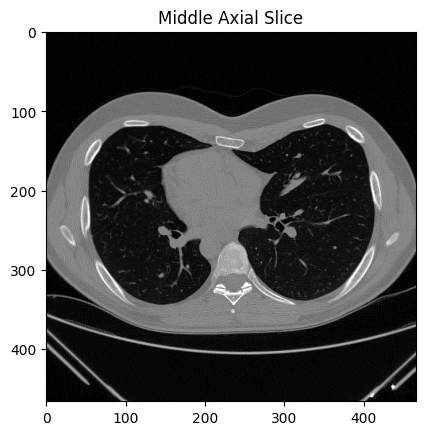

In [22]:
path = "/scratch/project_465001111/ct_clip/data_volumes/dataset/valid/valid_1/valid_1_a/valid_1_a_1.nii.gz"
img_data = nib.load(path)
img_data = img_data.get_fdata()
img_data = np.rot90(img_data, k=-1, axes=(0, 1))

df = pd.read_csv("/project/project_465001111/ct_clip/CT-CLIP-UT/metadata/valid_metadata.csv") #select the metadata
file_name = path.split("/")[-1]
row = df[df['VolumeName'] == file_name]
slope = float(row["RescaleSlope"].iloc[0])
intercept = float(row["RescaleIntercept"].iloc[0])
xy_spacing = float(row["XYSpacing"].iloc[0][1:][:-2].split(",")[0])
z_spacing = float(row["ZSpacing"].iloc[0])

# Define the target spacing values
target_x_spacing = 0.75
target_y_spacing = 0.75
target_z_spacing = 1.5

current = (z_spacing, xy_spacing, xy_spacing)
target = (target_z_spacing, target_x_spacing, target_y_spacing)

img_data = slope * img_data + intercept

img_data = img_data.transpose(2, 0, 1)

tensor = torch.tensor(img_data)
tensor = tensor.unsqueeze(0).unsqueeze(0)

img_data = resize_array(tensor, current, target)
img_data = img_data[0][0]
img_data= np.transpose(img_data, (1, 2, 0))

hu_min, hu_max = -1000, 1000
img_data = np.clip(img_data, hu_min, hu_max)

img_data = (((img_data ) / 1000)).astype(np.float32)
slices=[]

tensor = torch.tensor(img_data)
# Get the dimensions of the input tensor
target_shape = (480,480,240)

# Extract dimensions
h, w, d = tensor.shape

# Calculate cropping/padding values for height, width, and depth
dh, dw, dd = target_shape
h_start = max((h - dh) // 2, 0)
h_end = min(h_start + dh, h)
w_start = max((w - dw) // 2, 0)
w_end = min(w_start + dw, w)
d_start = max((d - dd) // 2, 0)
d_end = min(d_start + dd, d)

# Crop or pad the tensor
tensor = tensor[h_start:h_end, w_start:w_end, d_start:d_end]

pad_h_before = (dh - tensor.size(0)) // 2
pad_h_after = dh - tensor.size(0) - pad_h_before

pad_w_before = (dw - tensor.size(1)) // 2
pad_w_after = dw - tensor.size(1) - pad_w_before

pad_d_before = (dd - tensor.size(2)) // 2
pad_d_after = dd - tensor.size(2) - pad_d_before

tensor = torch.nn.functional.pad(tensor, (pad_d_before, pad_d_after, pad_w_before, pad_w_after, pad_h_before, pad_h_after), value=-1)
tensor = tensor.permute(2, 0, 1)
tensor = tensor.unsqueeze(0)
tensor = tensor.cpu().numpy()

plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')
plt.title("Middle Axial Slice")
plt.show()